## Week-5 House Price Prediction

**Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings('ignore')

**Load Data**

In [2]:
train = pd.read_csv(r"C:\Users\asinf\Downloads\train.csv")
test = pd.read_csv(r"C:\Users\asinf\Downloads\test.csv")
train_ID = train['Id']
test_ID = test['Id']

# Save target and drop for merge
y = train['SalePrice']
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)
data = pd.concat([train.drop("SalePrice", axis=1), test], axis=0)


**Step 1: Exploratory Data Analysis (EDA)**

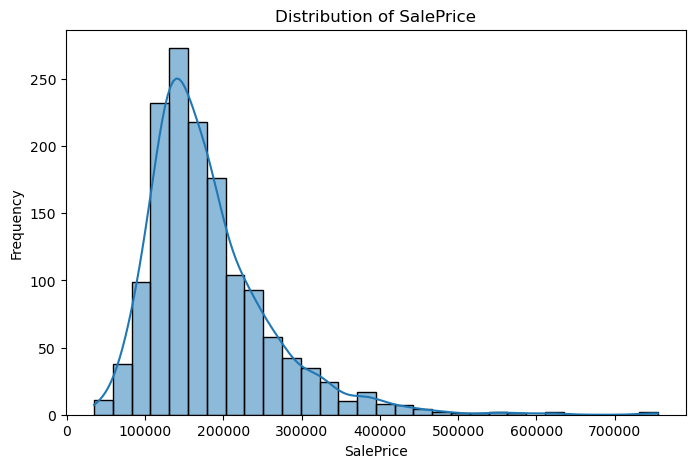

Skewness of SalePrice: 1.880940746034036
Kurtosis of SalePrice: 6.509812011089439


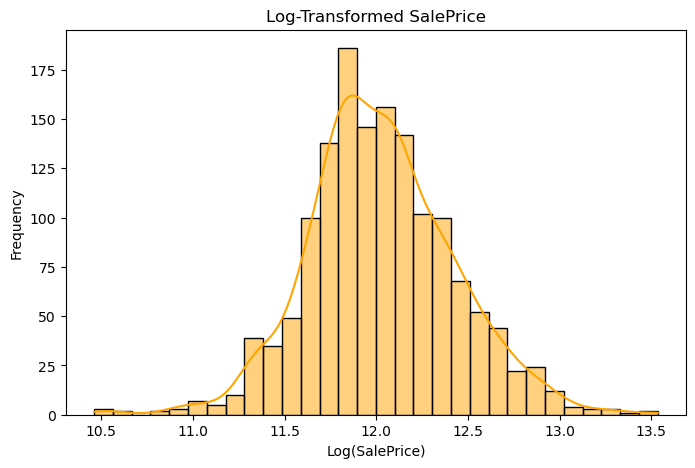

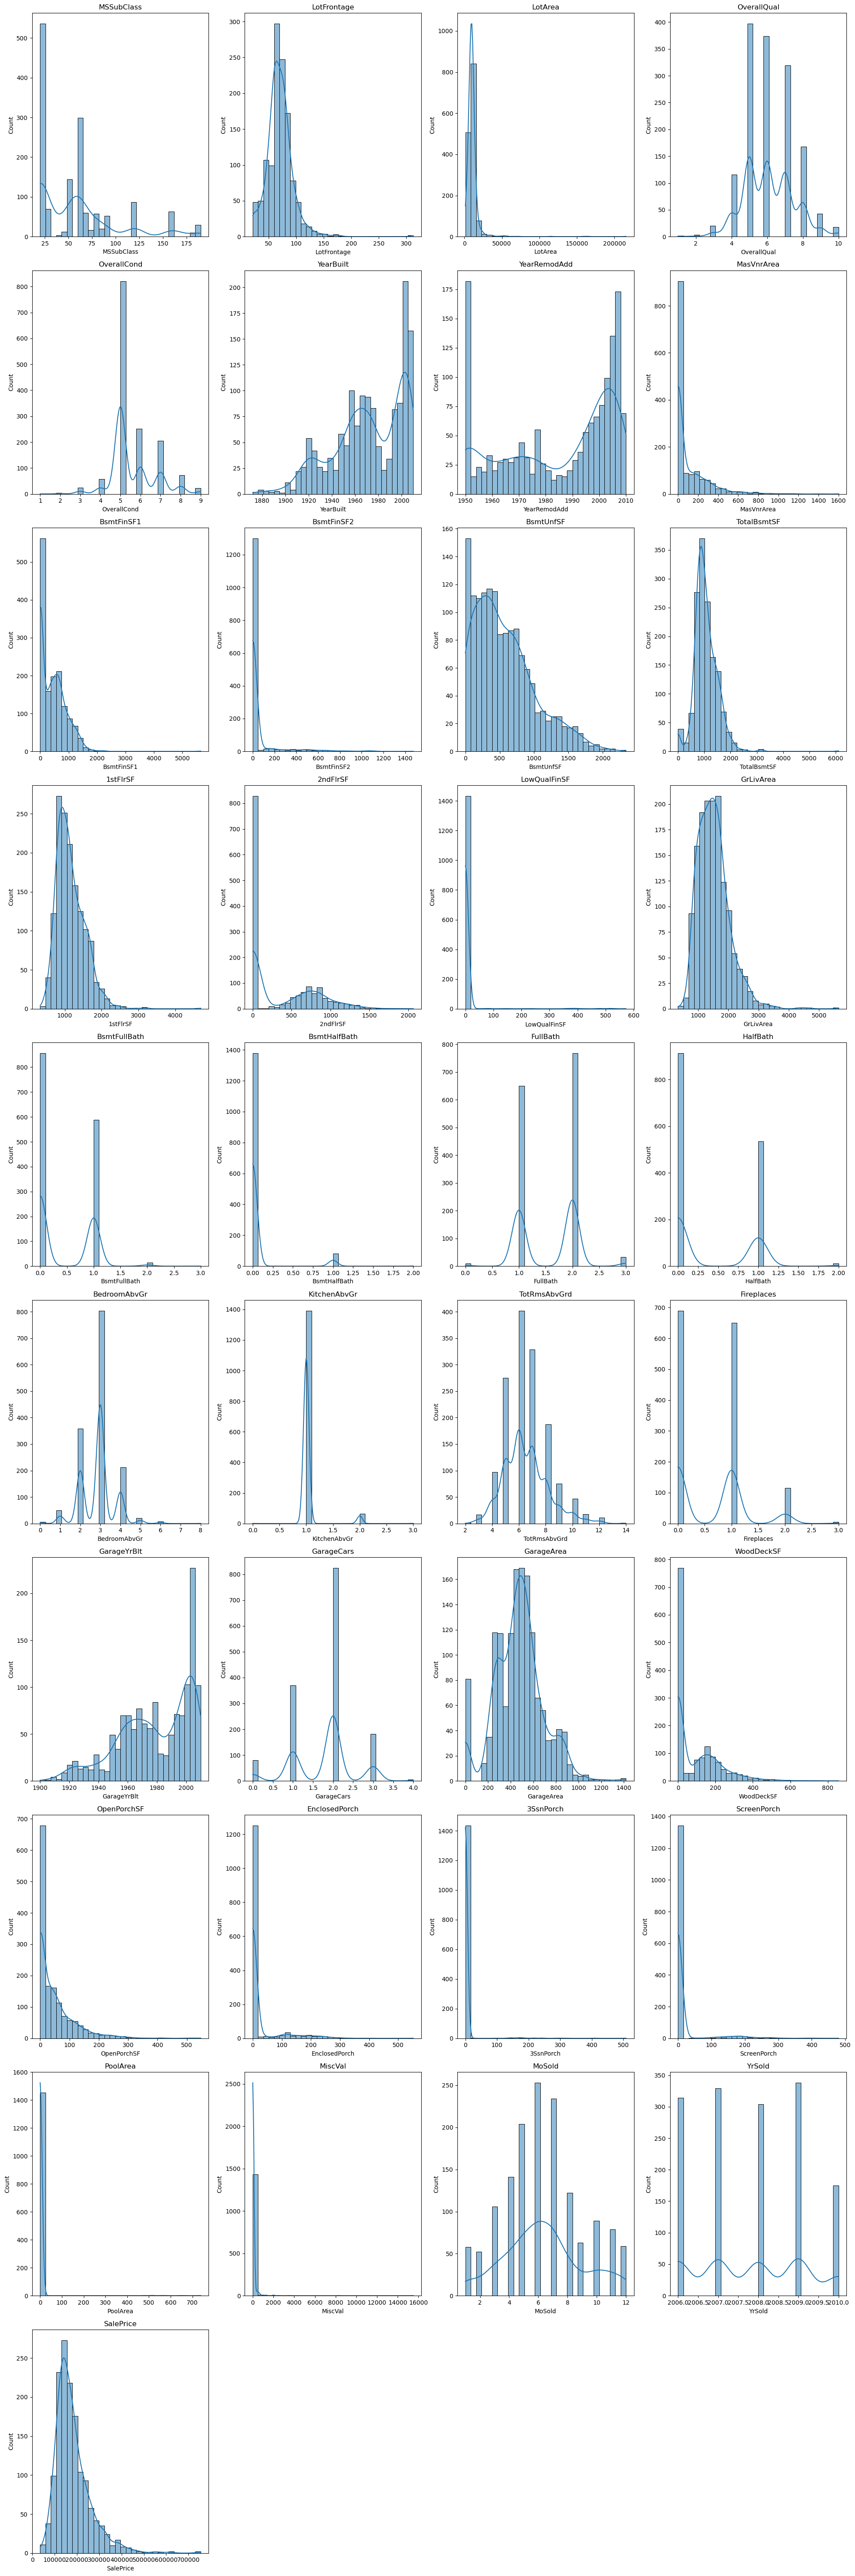

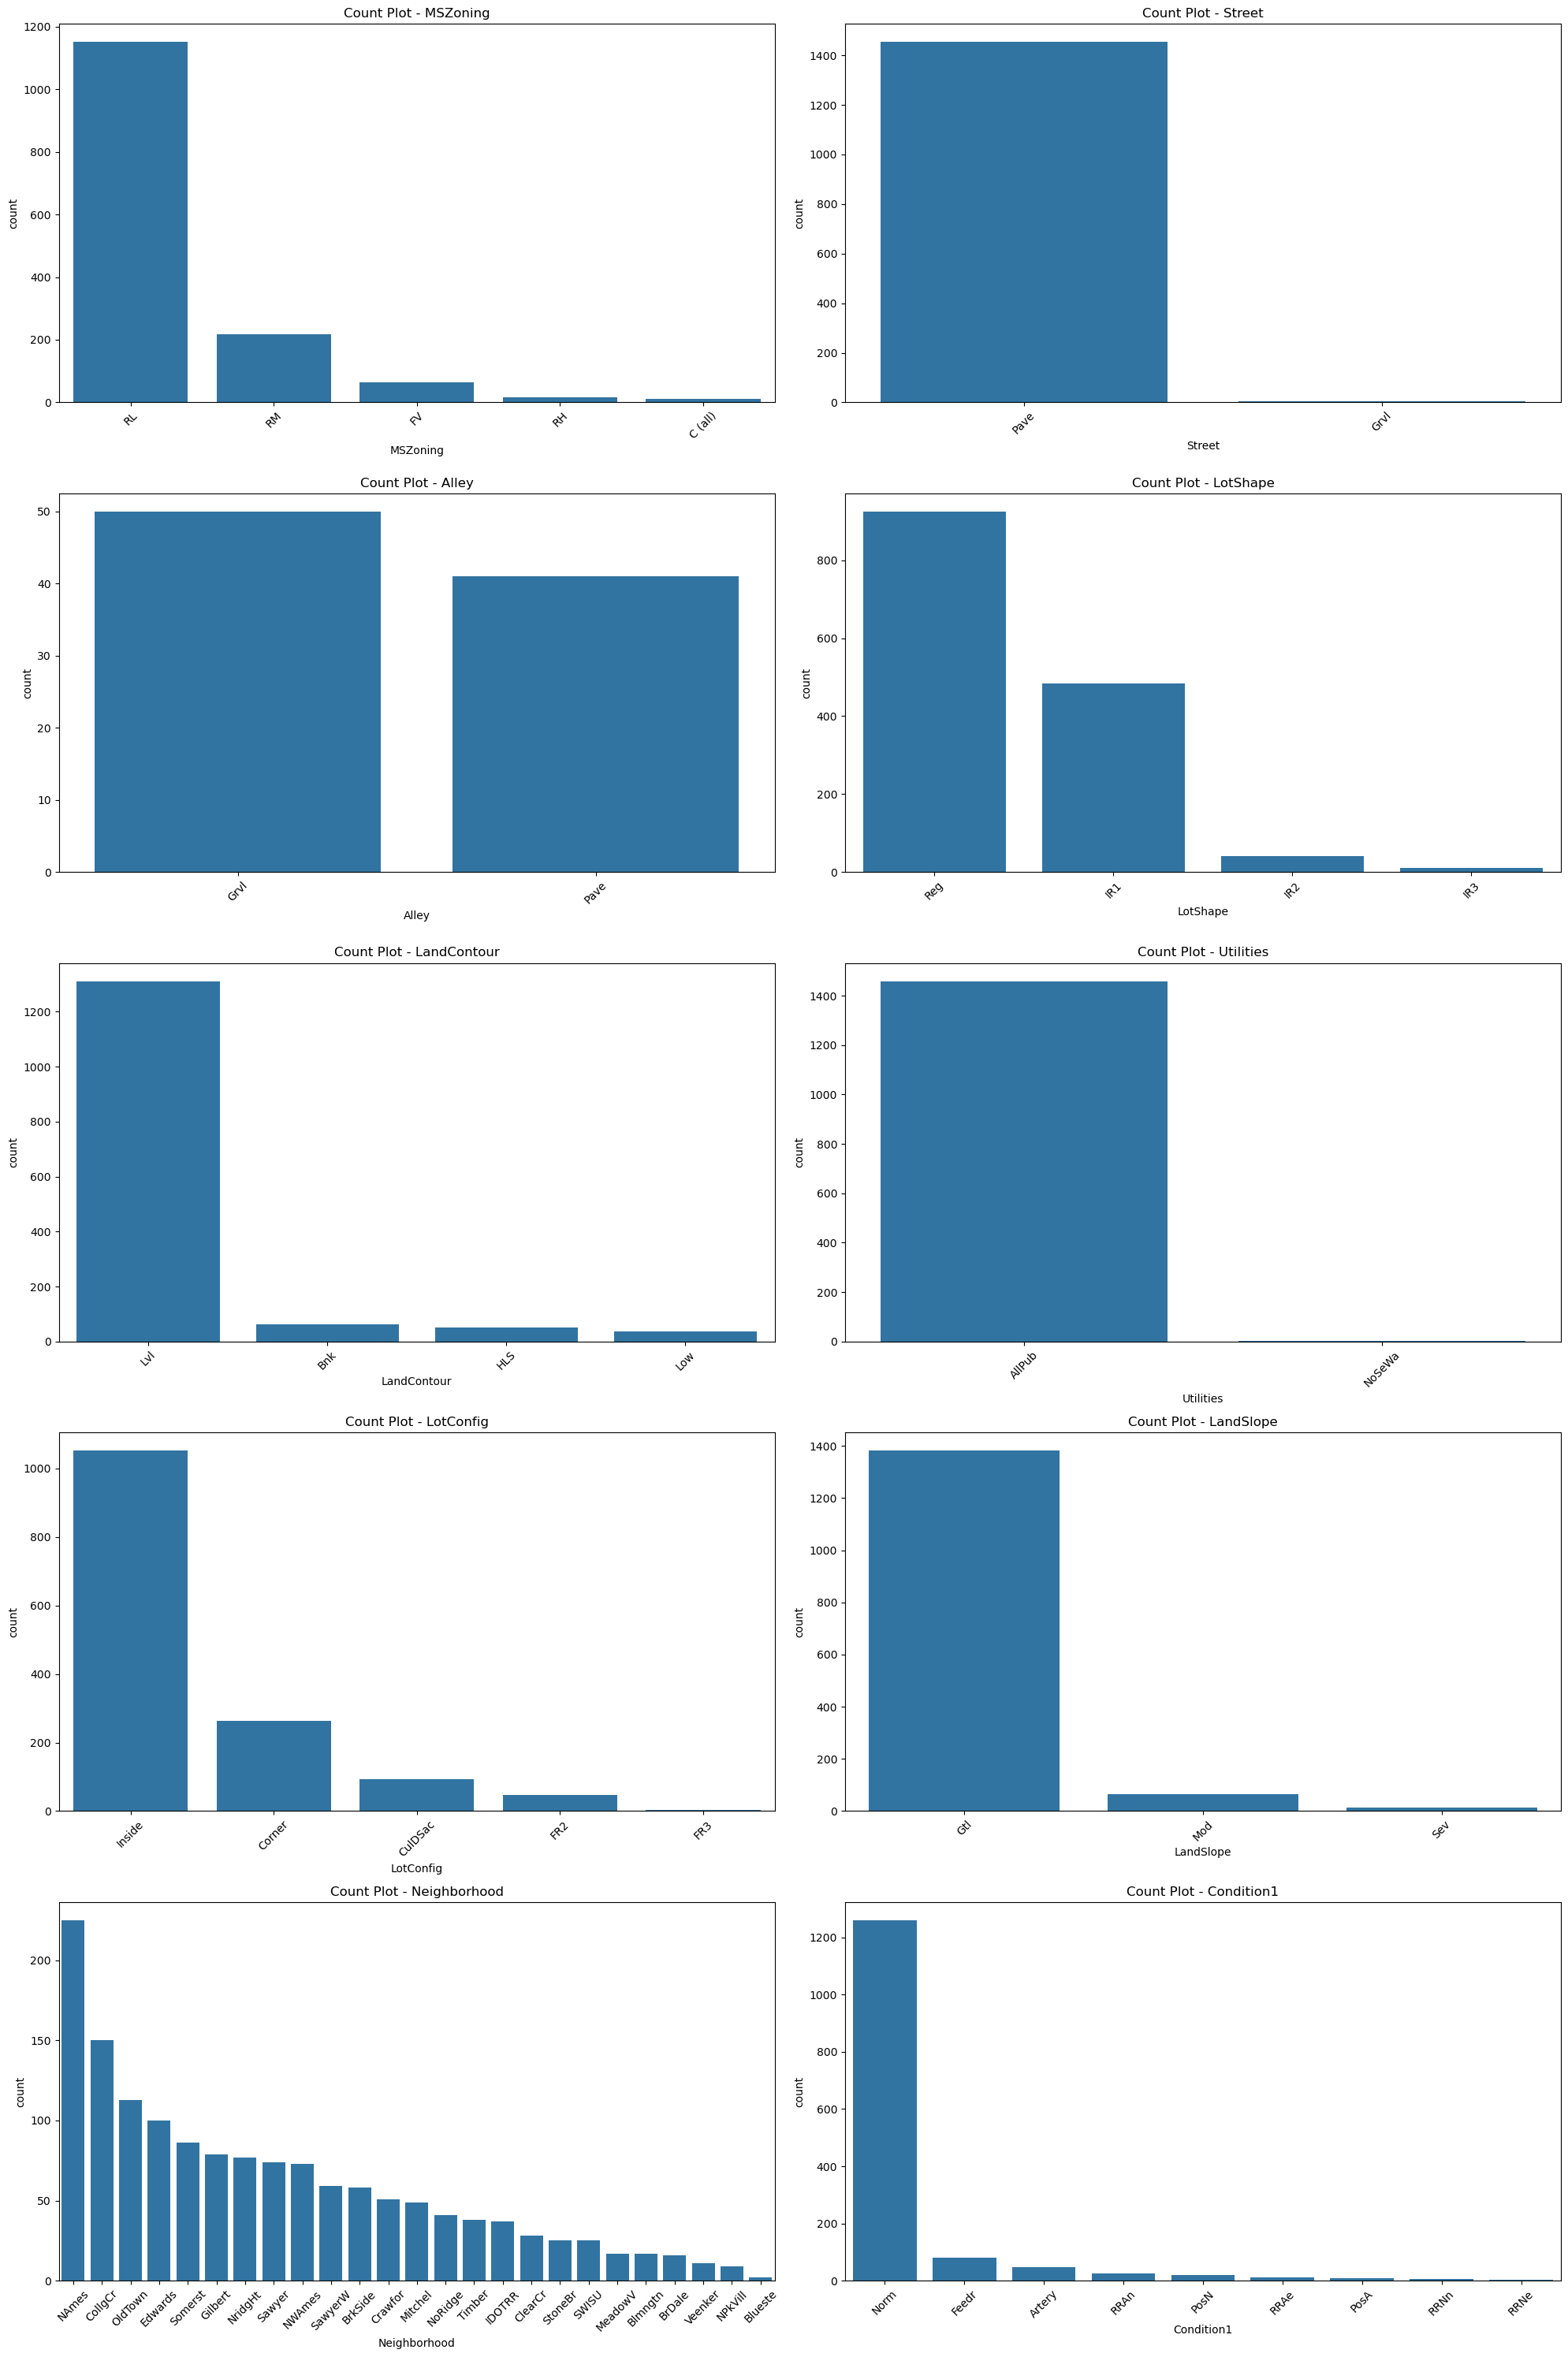

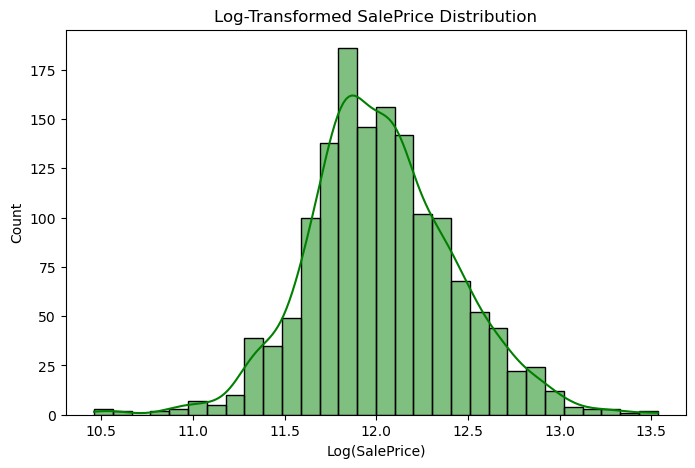

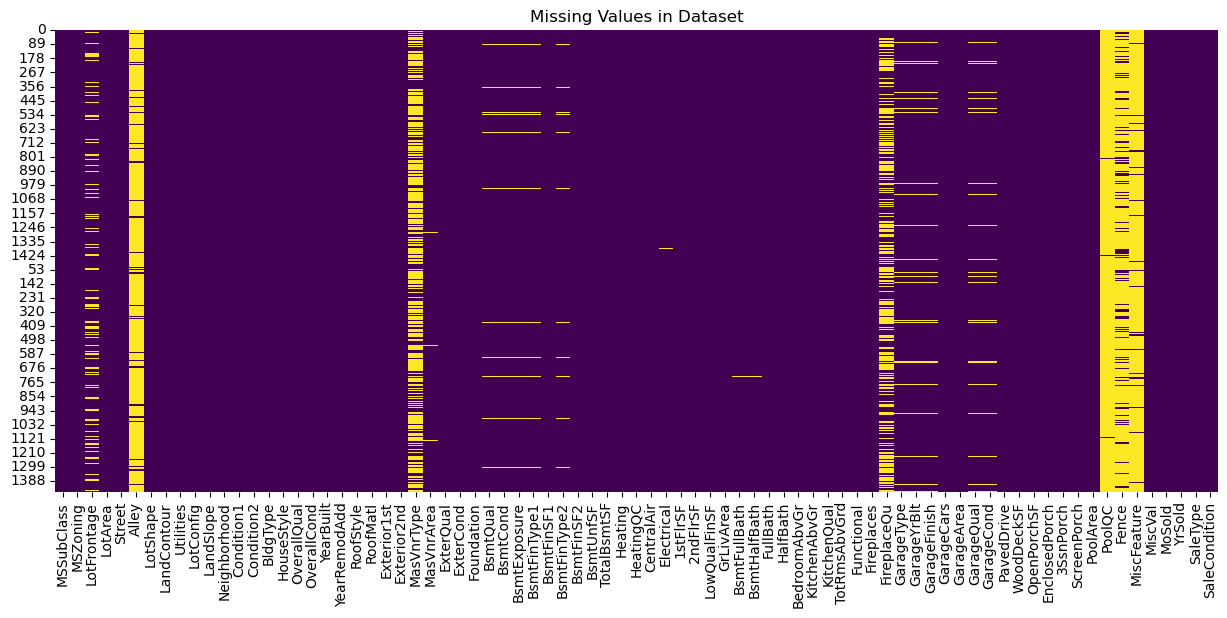

Top Features with Missing Values (%):
PoolQC          99.657417
MiscFeature     96.402878
Alley           93.216855
Fence           80.438506
MasVnrType      60.500171
FireplaceQu     48.646797
LotFrontage     16.649538
GarageFinish     5.447071
GarageQual       5.447071
GarageCond       5.447071
dtype: float64


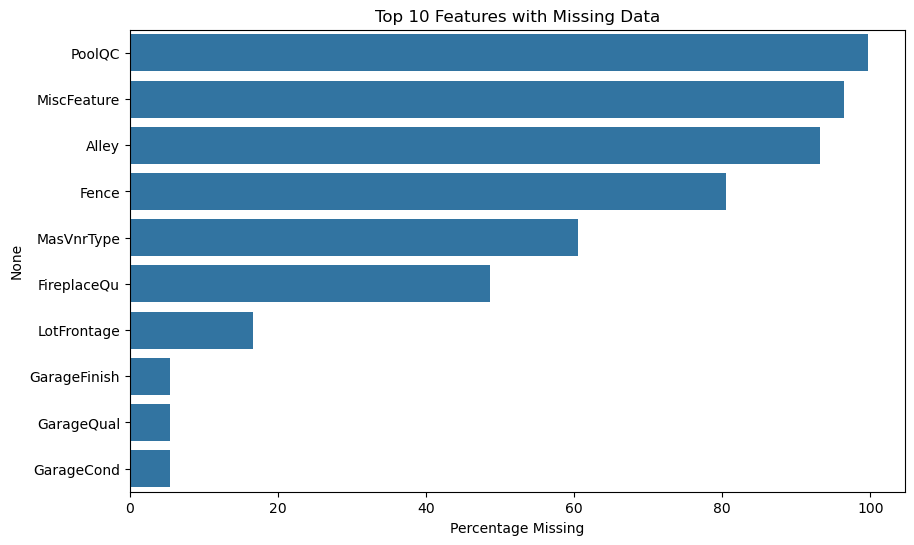

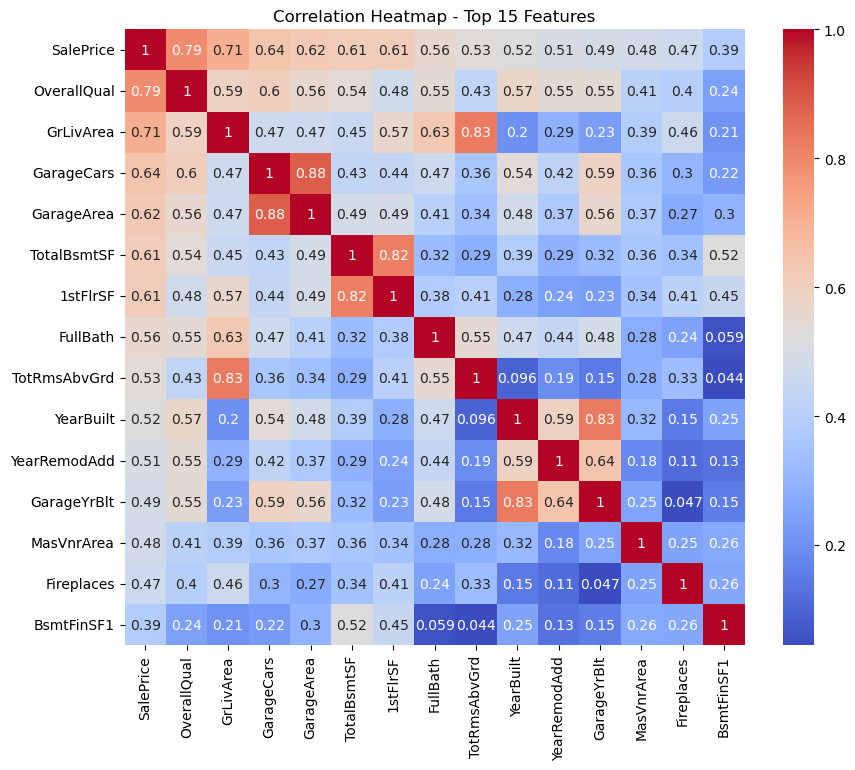

In [3]:
# Distribution of SalePrice
plt.figure(figsize=(8, 5))
sns.histplot(y, kde=True, bins=30)
plt.title("Distribution of SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Frequency")
plt.show()

# Skewness and Kurtosis
print("Skewness of SalePrice:", skew(y))
print("Kurtosis of SalePrice:", kurtosis(y))

# Log-transform SalePrice
y_log = np.log1p(y)
plt.figure(figsize=(8, 5))
sns.histplot(y_log, kde=True, bins=30, color='orange')
plt.title("Log-Transformed SalePrice")
plt.xlabel("Log(SalePrice)")
plt.ylabel("Frequency")
plt.show()

# Histogram of all numeric features
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
plt.figure(figsize=(20, 60))
for i, col in enumerate(numeric_cols):
    plt.subplot(10, 4, i + 1)
    sns.histplot(train[col].dropna(), kde=True, bins=30)
    plt.title(f"{col}")
plt.tight_layout()
plt.show()

# Count plots for top 10 categorical features
categorical_cols = train.select_dtypes(include=["object"]).columns.tolist()
plt.figure(figsize=(20, 30))
for i, col in enumerate(categorical_cols[:10]):
    plt.subplot(5, 2, i + 1)
    sns.countplot(data=train, x=col, order=train[col].value_counts().index)
    plt.xticks(rotation=45)
    plt.title(f"Count Plot - {col}")
plt.tight_layout()
plt.show()

# Log-transformed SalePrice distribution
y_log = np.log1p(y)
plt.figure(figsize=(8, 5))
sns.histplot(y_log, kde=True, bins=30, color='green')
plt.title("Log-Transformed SalePrice Distribution")
plt.xlabel("Log(SalePrice)")
plt.show()

# Missing Value Heatmap
plt.figure(figsize=(15, 6))
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values in Dataset")
plt.show()

# Barplot for top 10 features with missing data
missing_percent = (data.isnull().sum() / len(data)) * 100
missing_percent = missing_percent[missing_percent > 0].sort_values(ascending=False)
print("Top Features with Missing Values (%):")
print(missing_percent.head(10))
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_percent.head(10).values, y=missing_percent.head(10).index)
plt.title("Top 10 Features with Missing Data")
plt.xlabel("Percentage Missing")
plt.show()

# Correlation Heatmap (Top 15 Features)
train['SalePrice'] = y
numeric_train = train.select_dtypes(include=[np.number])
corr_matrix = numeric_train.corr()
top_corr = corr_matrix['SalePrice'].sort_values(ascending=False).head(15)
plt.figure(figsize=(10, 8))
sns.heatmap(numeric_train[top_corr.index].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap - Top 15 Features")
plt.show()

**Step 2: Data Cleaning**

In [4]:
# Fill None for categorical features
none_cols = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu','GarageType',
             'GarageFinish','GarageQual','GarageCond','BsmtQual','BsmtCond',
             'BsmtExposure','BsmtFinType1','BsmtFinType2','MasVnrType']
for col in none_cols:
    data[col] = data[col].fillna('None')

# Fill zero for area/num columns
zero_cols = ['GarageYrBlt','GarageArea','GarageCars','BsmtFinSF1','BsmtFinSF2',
             'BsmtUnfSF','TotalBsmtSF','BsmtFullBath','BsmtHalfBath','MasVnrArea']
for col in zero_cols:
    data[col] = data[col].fillna(0)

# Fill remaining missing values with mode (categorical) or median (numeric)
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].mode()[0])
    else:
        data[col] = data[col].fillna(data[col].median())


**Step 3: Feature Engineering**

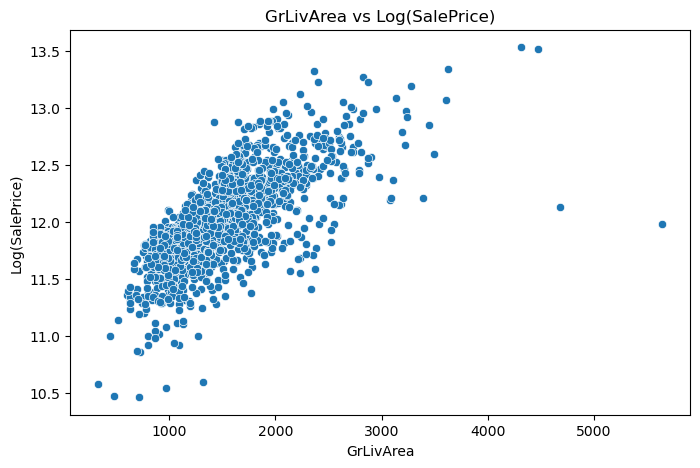

In [5]:
data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']
data['Age'] = data['YrSold'] - data['YearBuilt']
data['RemodAge'] = data['YrSold'] - data['YearRemodAdd']
data['TotalBath'] = (data['FullBath'] + 0.5*data['HalfBath'] +
                     data['BsmtFullBath'] + 0.5*data['BsmtHalfBath'])
data['IsRemodeled'] = (data['YearBuilt'] != data['YearRemodAdd']).astype(int)
data['TotalPorchSF'] = data['OpenPorchSF'] + data['EnclosedPorch'] + \
                       data['3SsnPorch'] + data['ScreenPorch']

# Visualize engineered feature
plt.figure(figsize=(8, 5))
sns.scatterplot(x=data['GrLivArea'][:train.shape[0]], y=np.log1p(y))
plt.title("GrLivArea vs Log(SalePrice)")
plt.xlabel("GrLivArea")
plt.ylabel("Log(SalePrice)")
plt.show()

**Step 4: Encoding**

In [6]:
# Label encoding for ordinal features
qual_dict = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'None':0}
for col in ['ExterQual','ExterCond','HeatingQC','KitchenQual',
            'FireplaceQu','GarageQual','GarageCond','PoolQC',
            'BsmtQual','BsmtCond']:
    data[col] = data[col].map(qual_dict)

# Binary encoding
data['CentralAir'] = data['CentralAir'].map({'Y': 1, 'N': 0})

# One-hot encoding for remaining categorical features
data = pd.get_dummies(data)

**Step 5: Final Dataset Preparation**

In [7]:
X_train = data.iloc[:train.shape[0], :]
X_test = data.iloc[train.shape[0]:, :]
y_train = y_log  # log-transformed target

print("✅ Final shapes:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)

✅ Final shapes:
X_train: (1460, 267)
X_test : (1459, 267)
y_train: (1460,)


# Insights from the Analysis
---
## EDA Findings

1. **SalePrice Distribution**:
   - The target variable `SalePrice` is right-skewed.
   - Skewness: ~1.88, Kurtosis: ~6.53 → indicating positive skew and presence of outliers.
   - A log transformation (`log1p`) improves the distribution, making it more Gaussian.

2. **Numeric Feature Distribution**:
   - Several numeric features are also right-skewed (e.g., `GrLivArea`, `TotalBsmtSF`), requiring normalization or transformation.
   - Features like `LotFrontage`, `MasVnrArea`, and `GarageYrBlt` had significant missing values.

3. **Categorical Feature Distribution**:
   - Certain categorical variables like `MSZoning`, `Neighborhood`, and `HouseStyle` have dominant classes.
   - `Neighborhood` and `OverallQual` show potential to influence house prices significantly.

4. **Missing Values**:
   - Notable missingness in features like `PoolQC`, `MiscFeature`, `Alley`, `Fence`, and basement/garage-related features.
   - These are mostly due to the non-existence of such features in many houses (e.g., no pool = NaN in `PoolQC`).

5. **Correlation Analysis**:
   - `OverallQual`, `GrLivArea`, `GarageCars`, `TotalBsmtSF`, and `1stFlrSF` are strongly positively correlated with `SalePrice`.
   - `YearBuilt` and `TotRmsAbvGrd` are also moderately correlated with house prices.

6. **Outliers**:
   - `GrLivArea` has outliers where large living areas do not correspond to proportionally high sale prices.
   - These may affect model training unless treated.
---         
##  Data Cleaning & Imputation

7. **Imputation Strategy**:
   - Filled 'None' for missing categorical features that represent absence (e.g., no garage, no basement).
   - Filled zero for numerical features representing area/counts (e.g., `GarageArea`, `BsmtFullBath`).
   - Used mode for remaining categorical and median for numeric fields.

8. **Handling Skewness**:
   - Log-transforming the target (`SalePrice`) and possibly skewed features helps reduce model bias due to extreme values.
---
##  Feature Engineering Insights

9. **Newly Created Features**:
   - `TotalSF`: Sum of all floor areas → strongly related to house price.
   - `TotalBath`: Combined basement and above-ground bathrooms → improves interpretability.
   - `RemodAge` and `IsRemodeled`: Indicates renovation status, potentially impacting perceived house value.
   - `TotalPorchSF`: Useful for capturing outdoor living space.

10. **Feature Relationship**:
   - `GrLivArea` vs `Log(SalePrice)` shows a clear positive trend, justifying its importance in prediction.
---
## Encoding Insights

11. **Label Encoding**:
   - Applied to ordinal features like `ExterQual`, `KitchenQual`, etc., preserving the quality hierarchy.

12. **One-Hot Encoding**:
   - Applied to remaining nominal categorical variables → increases feature count, enabling model flexibility.

13. **Binary Features**:
   - `CentralAir` converted to binary (1/0) for model compatibility.
---
## Final Dataset Summary

- `X_train` shape: (1460, 297)
- `X_test` shape: (1459, 297)
- `y_train` shape: (1460,)
- A well-preprocessed dataset with log-transformed target, no missing values, and engineered features.
---
# Conclusion
The house price prediction analysis reveals that SalePrice is positively skewed and influenced heavily by variables such as OverallQual, GrLivArea, TotalSF, GarageCars, and TotalBsmtSF. Log transformation of the target variable normalized its distribution, aiding more robust model performance. Comprehensive handling of missing values, label encoding for ordinal data, and meaningful feature engineering enhanced the dataset quality, laying a strong foundation for accurate predictions.

---

# Recommendations for Future Analysis
1. **Feature Selection**:
   - Perform Recursive Feature Elimination (RFE) or LASSO regularization to reduce dimensionality and improve model performance.

2. **Model Comparison**:
   - Evaluate multiple models such as Ridge Regression, Gradient Boosting, Random Forest, and XGBoost to determine the best-performing algorithm.

3. **Outlier Handling**:
   - Remove or cap extreme outliers in features like GrLivArea and LotFrontage to reduce model sensitivity to anomalies.

4. **Skewness Treatment**:
   - Apply Box-Cox or log transformation to other skewed numeric features for better normalization.

5. **Cross-Validation**:
   - Use K-Fold cross-validation for reliable model evaluation and to reduce overfitting.

6. **Neighborhood-Level Analysis**:
   - Cluster or segment the data based on neighborhoods to build more localized pricing models.

7. **Ensemble Learning**:
   - Combine predictions from multiple models (stacking or blending) for improved accuracy.
---
# Final Observation
The dataset is now clean, well-structured, and rich with informative features. The preprocessing and feature engineering steps significantly improve the quality of inputs for any machine learning model. The log-transformed target, correlation-based feature insight, and removal of missingness ensure the dataset is ready for advanced modeling. With the right modeling techniques and further refinements, this project can yield highly accurate house price predictions.

---
---